<img src="figure/clairvoyance_logo.png">

# Clairvoyance: Treatment effects estimation

## ML-AIM (http://vanderschaar-lab.com/)

This notebook describes a user-guide for treatment effects estimation using the Clairvoyance framework. We consider the case of time-varying treatments where, given static and temporal features we want to estimate the effect of a single treatment or a sequence of treatments on the patient outcome. For instance, using the static data (demographic information), temporal data (vitals, lab tests) and treatments administered over time, we can estimate whether the patient will need the ventilator under different possible treatment plans. These counterfactual trajectories can then be used to decide which treatment plan will give the best patient outcome. 

- Rolling window counterfactual prediction:
  - Example: Predict the effect of a sequence of treatments on the probability of the patient needing a ventilator. The projection horizon is equal to the length of the sequence of treatments for which we make the counterfactual predictions. 
 
<img src="figure/treatment-effects-definition.png">

To run this tutorial, you need:
### Temporal and static datasets for training and testing

If users come with their own temporal and static datasets for training and testing, the users should save those files as 'data_name_temporal_train_data_eav.csv.gz', 'data_name_static_train_data.csv.gz', 'data_name_temporal_test_data_eav.csv.gz', 'data_name_static_test_data.csv.gz' in '../datasets/data/data_name/' directory.

Note: the temporal data should contain information about the treatments administered over time.

### Assumptions needed for performing causal inference
For the selected temoporal data, users should check the necesary assumptions for performing causal inference using the data, namely overlap (positivity) and no hidden confounders. Overlap means that at each timestep, each patient has non-zero probability of being assigned each treatment option, no hidden confounders involves considering all variables that are affecting the treatment assignment and patient outcome at each timestep. 
If these assumptions do not hold, they will obtain bias estimates of the treatment effects. 


### Prerequisite
Clone https://github.com/jsyoon0823/time-series-automl.git to the current directory.

## Time-series prediction pipeline summary

<img src="figure/treatment-effects-block-diagram.png">

### Step 1: Load dataset
  - Extract csv files from the original raw datasets in ../datasets/data/data_name/ directory.  
  
### Step 2: Preprocess dataset
  - Preprocessing the raw data using various filters such as (1) replacing negative values to NaN, (2) do one-hot encidng for certain features, (3) do normalization.  
  
### Step 3: Define problem
  - Set the time-series prediction problem that we want to solve. For treatment effects, we only consider the 'online' prediction problem as we are interested in estimating counterfactual outcomes at different timesteps throughtout the patient trajectory. In addition, set the label, set the maximum sequence length, and set the features in the temporal dataset that should be considered as treatments. We also define the metric for evaluation and the task itself (whether classification or regression).

### Step 4: Impute dataset
  - Impute missing values in the preprocessed static and temporal datasets and return complete datasets.
  
### Step 5: Feature selection
  - Select the relevant static and temporal features to the labels. You can skip the feature selection (set feature selection method = None). For causal infernece, if feature selection is performed, one needs to ensure that the remaining features still satisfy the required identifiability assumptions. 
  
### Step 6: Treatment effects model fit and predict
  - After finishing the data preparation, we define the treatment effects models and train the model using the training dataset. The models capable of estimating counterfactual outcomes for a sequence of treatments into the future will have the option for selecting the projection horizon. After training, we use the trained model to estimating treatment effects on the testing dataset.
  
### Step 7: Visualize results
  - Visualize the various results such as performance, factual and counterfactual predictions and uncertainties.

## Step 0: Import necessary packages

Import necessary packages for the entire tutorials.

In [7]:
# Necessary packages
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('/Users/ioanabica/PycharmProjects/time-series-automl/')

from utils import PipelineComposer

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

## Step 1: Load dataset

Extract temporal and static datasets from 'data_name_temporal_train_data_eav.csv.gz', 'data_name_static_train_data.csv.gz', 'data_name_temporal_test_data_eav.csv.gz', 'data_name_static_test_data.csv.gz' in '../datasets/data/data_name/' directory.

- CSVLoader: Load csv files from the original raw datasets in ../datasets/data/data_name/ directory.
- file_names: mimic in this tutorial.

In [8]:
from datasets import CSVLoader

# Define data name
data_name = 'mimic_antibiotics'
# Define data dictionary
data_directory = '../datasets/data/'+data_name + '/' + data_name + '_'

# Load train and test datasets
data_loader_training = CSVLoader(static_file=data_directory + 'static_train_data.csv.gz',
                                 temporal_file=data_directory + 'temporal_train_data_eav.csv.gz')

data_loader_testing = CSVLoader(static_file=data_directory + 'static_test_data.csv.gz',
                                temporal_file=data_directory + 'temporal_test_data_eav.csv.gz')

dataset_training = data_loader_training.load()
dataset_testing = data_loader_testing.load()

print('Finish data loading.')

Finish data loading.


## Step 2: Preprocess dataset

Preprocess the raw data using multiple filters. In this tutorial, we replace all the negative values to NaN (using NegativeFilter), do one-hot encoding on 'admission_type' feature (using OneHotEncoder), and do MinMax Normalization (using Normalization). Preprocessing is done for both training and testing datasets. 
  - NegativeFilter: Replace negative values to NaN
  - OneHotEncoder: One hot encoding certain features
    - one_hot_encoding: input features that need to be one-hot encoded
  - Normalization (3 options): MinMax, Standard, None

In [9]:
from preprocessing import FilterNegative, OneHotEncoder, Normalizer

# (1) filter out negative values
negative_filter = FilterNegative()
# (2) one-hot encode categorical features
one_hot_encoding = 'admission_type'
onehot_encoder = OneHotEncoder(one_hot_encoding_features=[one_hot_encoding])
# (3) Normalize features: 3 options (minmax, standard, none)
normalization = 'minmax'
normalizer = Normalizer(normalization)

# Data preprocessing
filter_pipeline = PipelineComposer(negative_filter, onehot_encoder, normalizer)

dataset_training = filter_pipeline.fit_transform(dataset_training)
dataset_testing = filter_pipeline.transform(dataset_testing)

print('Finish preprocessing.')

Finish preprocessing.


## Step 3: Define problem   

Set the treatment-effects causal inference problem that we want to solve. As explained at the beginning of the notebook, estimating treatment effects over time makes sense only in the 'online' problem setting.  In addition, set the label, set the maximum sequence length, and set the treatment features. We also define the metric for evaluation and the task itself (whether classification or regression). In this tutorial, we predict the effect of treatments on ventilator usage. 
  - problem: 'online'(rolling window prediction) 
    - 'online': preditcion at every time stamps of the time-series
  - max_seq_len: maximum sequence length of time-series sequence
  - label_name: the column name for the label(s)
  - treatment: the column name for treatment (currently only binare treatment is supported)
  - window: x-hour ahead prediction (difference between consecutive time steps).
  
  - other parameters:
    - metric_name: auc, apr, mse, mae
    - task: classification or regression

In [10]:
from preprocessing import ProblemMaker

# Define parameters
problem = 'online'
max_seq_len = 20
label_name = 'ventilator'
treatment = ['antibiotics']
window = 1

# Define problem 
problem_maker = ProblemMaker(problem=problem, label=[label_name],
                             max_seq_len=max_seq_len, treatment=treatment, window=window)

dataset_training = problem_maker.fit_transform(dataset_training)
dataset_testing = problem_maker.fit_transform(dataset_testing)

# Set other parameters
metric_name = 'auc'
task = 'classification'

metric_sets = [metric_name]
metric_parameters =  {'problem': problem, 'label_name': [label_name]}

print('Finish defining problem.')

100%|██████████| 604/604 [00:02<00:00, 275.02it/s]


Finish defining problem.


## Step 4: Impute dataset

Impute missing values in the preprocessed static and temporal datasets and return complete datasets.
  - Static imputation (6 options): mean, median, mice, missforest, knn, gain
  - Temporal imputation (8 options): mean, median, linear, quadratic, cubic, spline, mrnn, tgain

In [11]:
from imputation import Imputation

# Set imputation models
static_imputation_model = 'median'
temporal_imputation_model = 'linear'

# Impute the missing data
static_imputation = Imputation(imputation_model_name = static_imputation_model, data_type = 'static')
temporal_imputation = Imputation(imputation_model_name = temporal_imputation_model, data_type = 'temporal')

imputation_pipeline = PipelineComposer(static_imputation, temporal_imputation)

dataset_training = imputation_pipeline.fit_transform(dataset_training)
dataset_testing = imputation_pipeline.transform(dataset_testing)

print('Finish imputation.')

100%|██████████| 604/604 [00:03<00:00, 163.82it/s]

Finish imputation.


## Step 5: Feature selection

Select the relevant static and temporal features to the labels. If you do not want, we can skip the feature selection (set feature selection method = None).
  - feature selection method: 
      - feature_selection_model: greedy-addtion, greedy-deletion, recursive-addition, recursive-deletion, None
      - feature_number: selected featuer number
      
After feature selection, the user needs to ensure that the assumptions needed for causal inference still hold. 

In [12]:
from feature_selection import FeatureSelection

# Set feature selection parameters
static_feature_selection_model = None
temporal_feature_selection_model = None
static_feature_selection_number = None
temporal_feature_selection_number = None

# Select relevant features
static_feature_selection = \
FeatureSelection(feature_selection_model_name = static_feature_selection_model,
                 feature_type = 'static', feature_number = static_feature_selection_number,
                 task = task, metric_name = metric_name,
                 metric_parameters = metric_parameters)

temporal_feature_selection = \
FeatureSelection(feature_selection_model_name = temporal_feature_selection_model,
                 feature_type = 'temporal', feature_number = temporal_feature_selection_number,
                 task = task, metric_name = metric_name,
                 metric_parameters = metric_parameters)

feature_selection_pipeline = PipelineComposer(static_feature_selection, temporal_feature_selection)

dataset_training = feature_selection_pipeline.fit_transform(dataset_training)
dataset_testing = feature_selection_pipeline.transform(dataset_testing)

print('Finish feature selection.')

Finish feature selection.


## Step 6: Treatment-effects model fit and predict

After finishing the data preparation, we define the treatment effect models (3 options: Counterfactual Recurrent Network (CRN), Recurrent Marginal Structural Models (RMSNs) and GANITE). Note that GANITE is a treatments effect model for the static setting; the implementation of GANITE in this package processes the patient history by stacking the a number of previous timsteps specified by the user through stack_dim and can only be used for one-step ahead prediction of treatment effects. 

For CRN and RMSN, a projection_horizon can set when fitting the models for estimating counterfactual trajectories. The projection horizon is equal to the length of the sequence of treatments for which we make the counterfactual predictions.

We then train the treatment effects model model using the training dataset. We set validation set as the 20% of the training set for early stopping and best model saving. 

After training, we use the trained model to:
- predict the factual outcomes of the testing dataset.
- estimate counterfactual trajectories for a sequence of future treatments. 

Each model has different types of hyperparameters that need to be set. 

- Hyperparameters needed for the Counterfactual Recurrent Network:
  - hyperparameters for encoder:
      - rnn_hidden_units: hidden dimensions in the LSTM unit
      - rnn_keep_prob: keep probability used for variational dropout in the LSTM unit
      - br_size: size of the balancing representation
      - fc_hidden_units: hidden dimensions of the fully connected layers used for treatment classifier and predictor
      - batch_size: number of samples in mini-batch
      - num_epochs: number of epochs
      - learning_rate: learning rate
      - max_alpha: alpha controls the trade-off between building tratment invariant representations (domain discrimination) and being able to predict outcomes (outcome prediction); during training, CRN uses an exponentially increasing schedule for alpha from 0 to max_alpha
  - hyperparameters for decoder:
      - the decoder requires the same hyperparameters as the encoder with the exception of the rnn_hidden_units 
        which is set to be equal to the br_size of the encoder
        
        
- Hyperparameters for Recurrent Marginal Structural Networks:
    - hyperparameters for encoder:
        - dropout_rate: dropout probability used for variational
        - rnn_hidden_units: hidden dimensions in the LSTM unit
        - batch_size: number of samples in mini-batch
        - num_epochs: number of epochs
        - learning_rate: learning rate
        - max_norm: max gradient norm used for gradient clipping during training
        
    - hyperparameters for decoder:
        - the decoder requires the same hyperparameters as the encoder. 

  
- Hyperparameters for GANITE:
  - batch size: number of samples in mini-batch
  - alpha: parameter trading off between discriminator loss and supervised loss for the generator training
  - learning_rate: learning rate
  - hidden_units: hidden dimensions of the fully connected layers used in the networks
  - stack_dim: number of timesteps to stack
  
  
All models have the following common parameters:
  - static_mode: how to utilize static features (concatenate or None)
  - time_mode: how to utilize time information (concatenate or None)
  - taks: 'classification' or 'regression'

In [14]:
from treatments.treatments import treatment_effects_model

# Set the treatment effects model
model_name = 'CRN'
projection_horizon = 5

# Set up validation for early stopping and best model saving
dataset_training.train_val_test_split(prob_val=0.2, prob_test = 0.0)

if model_name == 'CRN':
    model_parameters={'encoder_rnn_hidden_units': 128,
                      'encoder_br_size': 64,
                      'encoder_fc_hidden_units':128,
                      'encoder_learning_rate': 0.001,
                      'encoder_batch_size': 256,
                      'encoder_keep_prob': 0.9,
                      'encoder_num_epochs': 100,
                      'encoder_max_alpha': 1.0,
                      'decoder_br_size': 64,
                      'decoder_fc_hidden_units': 128,
                      'decoder_learning_rate': 0.001,
                      'decoder_batch_size': 512,
                      'decoder_keep_prob': 0.9,
                      'decoder_num_epochs': 100,
                      'decoder_max_alpha': 1.0,
                      'projection_horizon': 5,
                      'static_mode': 'concatenate',
                      'time_mode': 'concatenate'}
    treatment_model = treatment_effects_model(model_name, model_parameters, task='classification')
    treatment_model.fit(dataset_training)
    
elif model_name == 'RMSN':
    hyperparams_encoder_iptw = {
        'dropout_rate': 0.1,
        'memory_multiplier': 4,
        'num_epochs': 100,
        'batch_size': 64,
        'learning_rate': 0.01,
        'max_norm': 0.5}

    hyperparams_decoder_iptw = {
        'dropout_rate': 0.1,
        'memory_multiplier': 2,
        'num_epochs': 100,
        'batch_size': 512,
        'learning_rate': 0.001,
        'max_norm': 4.0}

    model_parameters={'hyperparams_encoder_iptw': hyperparams_encoder_iptw, 
                      'hyperparams_decoder_iptw': hyperparams_decoder_iptw,
                      'static_mode': 'concatenate',
                      'time_mode': 'concatenate', 
                      'model_dir': 'tmp/', 
                      'model_name': 'rmsn_test'}
    treatment_model = treatment_effects_model(model_name, model_parameters, task='classification')
    treatment_model.fit(dataset_training, projection_horizon=projection_horizon)
    
elif model_name == 'GANITE':
    hyperparams = {'batch_size': 256, 
                   'alpha': 1.0, 
                   'hidden_dims': 128, 
                   'learning_rate': 0.001, 
                   'stack_dim': 4}
    
    model_parameters={'hyperparams': hyperparams,
                     'static_mode': 'concatenate',
                     'time_mode': 'concatenate',}

    #treatment_model = treatment_effects_model(model_name, model_parameters, task='classification')
    treatment_model = GANITE_Model(hyperparams=hyperparams, task=task, static_mode='concatenate', time_mode='concatenate')
    treatment_model.fit(dataset_training)

# Return the factual predictions on the testing set
test_y_hat = treatment_model.predict(dataset_testing)

print('Finish treatment effects model training and testing.')

Model id
crn_model
Hyperparams CRN
{'rnn_hidden_units': 128, 'br_size': 64, 'fc_hidden_units': 128, 'learning_rate': 0.001, 'batch_size': 256, 'rnn_keep_prob': 0.9, 'num_epochs': 100, 'max_alpha': 1.0}
{'rnn_hidden_units': 64, 'br_size': 64, 'fc_hidden_units': 128, 'learning_rate': 0.001, 'batch_size': 512, 'rnn_keep_prob': 0.9, 'num_epochs': 100, 'max_alpha': 1.0}


I0927 00:28:25.306213 4491158976 CRN_Base.py:209] Epoch 0 | total loss = 1.8799456357955933 | outcome loss = 0.6271281242370605 | treatment loss = 1.2528175115585327 | current alpha = 0.0 
I0927 00:28:25.604413 4491158976 CRN_Base.py:216] Epoch 0 Summary| Validation loss = 1.8379987478256226 | Validation loss outcomes = 0.6129125952720642 | Validation loss treatments = 1.2250862121582031
I0927 00:28:27.502315 4491158976 CRN_Base.py:209] Epoch 1 | total loss = 1.727207899093628 | outcome loss = 0.5263784527778625 | treatment loss = 1.2008293867111206 | current alpha = 0.049958374957880025 
I0927 00:28:27.704648 4491158976 CRN_Base.py:216] Epoch 1 Summary| Validation loss = 1.6799942255020142 | Validation loss outcomes = 0.5053459405899048 | Validation loss treatments = 1.1746482849121094
I0927 00:28:29.143657 4491158976 CRN_Base.py:209] Epoch 2 | total loss = 1.679557204246521 | outcome loss = 0.4391331672668457 | treatment loss = 1.2404240369796753 | current alpha = 0.0996679946249559 

Finish treatment effects model training and testing.


Finish predictor model evaluation.
Overall performance


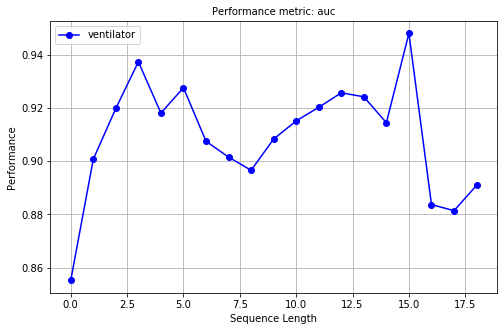

[<Figure size 576x360 with 1 Axes>]

In [15]:
from evaluation import Metrics
from evaluation import print_performance

# Evaluate predictor model
result = Metrics(metric_sets, metric_parameters).evaluate(dataset_testing.label, test_y_hat)
print('Finish predictor model evaluation.')

print('Overall performance')
print_performance(result, metric_sets, metric_parameters)

In [16]:
np.mean(result['ventilator + auc'])

0.8638164127406414

## Step 7: Visualize counterfactual estimations

(1) Visualize the estimated counterfactual trajectories for user defined treatment options.

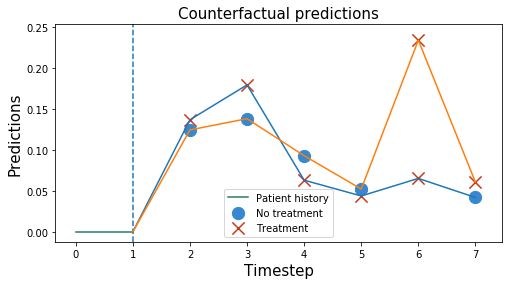

In [18]:
from evaluation import print_counterfactual_predictions

if model_name in ['CRN', 'RMSN']:
  # Predict and visualize counterfactuals for the sequence of treatments indicated by the user through the treatment_options
  treatment_options = np.array([[[1], [1], [1], [1], [1], [0]],
                                  [[0], [0], [0], [0], [1], [1]]])
  history, counterfactual_traj = treatment_model.predict_counterfactual_trajectories(dataset=dataset_testing,
                                                                            patient_id=2, timestep=2,
                                                                            treatment_options=treatment_options)

  print_counterfactual_predictions(patient_history=history, treatment_options=treatment_options,
                                   counterfactual_predictions=counterfactual_traj)